In [1]:
import typing as T

import numpy as np
import numpy.typing as npt
import scipy as sp

from matplotlib import pyplot as plt
import matplotlib.patches as patches

from pydrake.solvers import (
    MathematicalProgram,
    MathematicalProgramResult,
    Solve,
    SolverOptions,
    CommonSolverOption, 
    IpoptSolver,
    GurobiSolver
)
from pydrake.symbolic import Polynomial, Variable, Variables, Evaluate, Expression
from sdp import create_sdp_relaxation, _get_sol_from_svd

from pydrake.math import eq, le, ge

from util import timeit, YAY, WARN, INFO, ERROR

import math
from tqdm import tqdm

import matplotlib.pyplot as plt
import mpld3
import numpy as np
from IPython.display import HTML, display
from pydrake.all import  DiagramBuilder 
from pydrake.solvers import MathematicalProgram, Solve

# from underactuated import ConfigureParser, running_as_notebook
from underactuated import running_as_notebook
from underactuated.quadrotor2d import Quadrotor2D, Quadrotor2DVisualizer

if running_as_notebook:
    mpld3.enable_notebook()

from enum import Enum
from typing import List, Tuple

import numpy as np
import numpy.typing as npt
import pydrake.symbolic as sym
from pydrake.math import eq, ge
from pydrake.solvers import (
    Binding,
    LinearConstraint,
    LinearEqualityConstraint,
    MathematicalProgram,
    Solve,
)

from utilities import unit_vector

from sdp import (
    _collect_bounding_box_constraints, _quadratic_cost_binding_to_homogenuous_form, _quadratic_cost_binding_to_homogenuous_form, _linear_bindings_to_homogenuous_form,
    _generic_constraint_bindings_to_polynomials, _assert_max_degree, _construct_symmetric_matrix_from_triang, _generic_constraint_binding_to_polynomials,
    _get_monomial_coeffs, _get_sol_from_svd, _linear_binding_to_expressions, _quadratic_polynomial_to_homoenuous_form, 
    _generic_constraint_bindings_to_polynomials,
)
from sdp_birotor import get_solution_from_X, solve_sdp_birotor

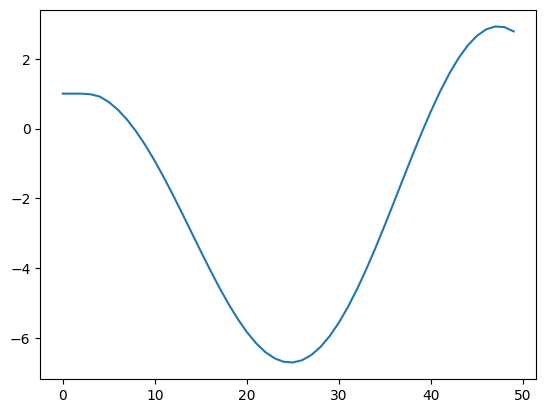

In [11]:
N = 50
c = np.ones(N)
s = np.zeros(N)
dc = np.zeros(N)
ds = np.zeros(N)
dth = np.ones(N) * 0.7

dt = 0.2
for n in range(0, N-1):
    c[n+1] = c[n] + dt * dc[n]
    s[n+1] = s[n] + dt * ds[n]
    if n <=3:
        ddth_n = 3
    else:
        ddth_n = 0
    dc[n+1] = dc[n] - dt * ( ddth_n*s[n] + dth[n]*ds[n] )
    ds[n+1] = ds[n] + dt * ( ddth_n*c[n] + dth[n]*dc[n] )
    
plt.plot(list(range(0, N)), c)

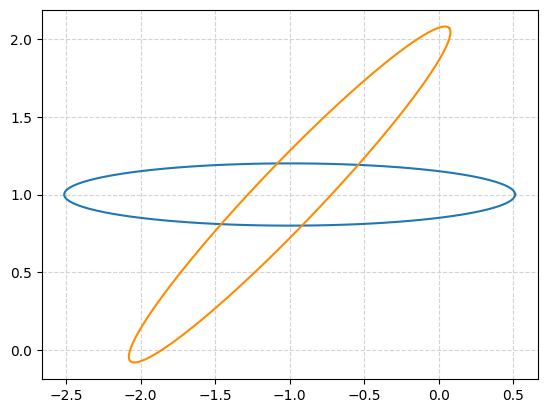

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from math import pi, cos, sin


def make_ellipsoid_constraint(vars, center, radii, t_rot):
    B = np.array([[np.cos(t_rot) , -np.sin(t_rot)],[np.sin(t_rot), np.cos(t_rot)]])  
    B = B @ np.diag((radii))
    # {Bu + center | |u|_2 <= 1}
    # {x | (x-center).T A.T A (x-center) <= 1 }
    A = np.linalg.inv(B)
    # {x | (x-center).T G (x-center) <= 1 }
    G = A.T @ A
    vars = np.array(vars)
    return (vars - center).T @ G @ (vars-center) >= 1


u=-1.       #x-position of the center
v=1      #y-position of the center
a=np.sqrt(2)+0.1       #radius on the x-axis
b=0.2      #radius on the y-axis
t_rot=pi/4 #rotation angle

t = np.linspace(0, 2*pi, 100)
Ell = np.array([a*np.cos(t) , b*np.sin(t)])  
#u,v removed to keep the same center location

B = np.array([[cos(t_rot) , -sin(t_rot)],[sin(t_rot) , cos(t_rot)]])  
     #2-D rotation matrix

Ell_rot = np.zeros((2,Ell.shape[1]))
for i in range(Ell.shape[1]):
    Ell_rot[:,i] = np.dot(R_rot,Ell[:,i])

plt.plot( u+Ell_rot[0,:] , v+Ell_rot[1,:],'darkorange' )    #rotated ellipse
plt.grid(color='lightgray',linestyle='--')
plt.show()

In [2]:
import matplotlib.pylab as plt
import scipy.sparse as sparse


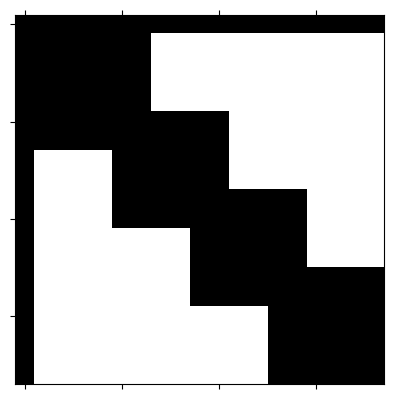

In [14]:
A = np.eye(19)
A[:, 0] = np.ones(19)
A[0, :] = np.ones(19)
A[1:7, 1:7] = np.ones((6,6))
A[5:11, 5:11] = np.ones((6,6))
A[9:15, 9:15] = np.ones((6,6))
A[13:19, 13:19] = np.ones((6,6))
plt.tick_params( labelleft = False ,
                labelbottom = False, bottom = False, top = False)
plt.spy(A)


In [9]:
a = Expression(0)
a.Evaluate()

0.0

In [2]:
def add_constraints_to_psd_mat_from_prog(prog:MathematicalProgram, relaxed_prog:MathematicalProgram, X:npt.NDArray, multiply_equality_constraints:bool):
    DEGREE_QUADRATIC = 2  # We are only relaxing (non-convex) quadratic programs
    
    decision_vars = np.array( sorted(prog.decision_variables(), key=lambda x: x.get_id()) )
    num_vars = ( len(decision_vars) + 1 )
    assert X.shape == (num_vars, num_vars) # else something is off

    basis = np.flip(sym.MonomialBasis(decision_vars, DEGREE_QUADRATIC))
    
    bounding_box_eqs, bounding_box_ineqs = _collect_bounding_box_constraints(
        prog.bounding_box_constraints()
    )

    has_linear_costs = len(prog.linear_costs()) > 0
    if has_linear_costs:
        raise NotImplementedError("Linear costs not yet implemented!")

    has_quadratic_costs = len(prog.quadratic_costs()) > 0
    if has_quadratic_costs:
        quadratic_costs = prog.quadratic_costs()
        Q_cost = [
            _quadratic_cost_binding_to_homogenuous_form(c, basis, num_vars)
            for c in quadratic_costs
        ]
        for Q in Q_cost:
            c = np.trace(Q.dot(X))
            relaxed_prog.AddCost(c)

    has_linear_eq_constraints = (
        len(prog.linear_equality_constraints()) > 0 or len(bounding_box_eqs) > 0
    )
    A_eq = None
    if has_linear_eq_constraints:
        A_eq = _linear_bindings_to_homogenuous_form(
            prog.linear_equality_constraints(), bounding_box_eqs, decision_vars
        )
        m,_ = A_eq.shape
        I = np.eye(num_vars)
        j = 0
        if multiply_equality_constraints:
            num_cons = num_vars
        else:
            num_cons = 1

        np.random.seed(1)
        for a in A_eq:
            for i in range(num_cons):
                j += 1
                A = np.outer(a, I[i])
                relaxed_prog.AddLinearConstraint( np.sum( X * ( A + A.T ) ) == 0 )

    has_linear_ineq_constraints = (
        len(prog.linear_constraints()) > 0 or len(bounding_box_ineqs) > 0
    )
    A_ineq = None
    if has_linear_ineq_constraints:
        A_ineq = _linear_bindings_to_homogenuous_form(
            prog.linear_constraints(), bounding_box_ineqs, decision_vars
        )
        m,_ = A_ineq.shape

        multiplied_constraints = ge(A_ineq.dot(X).dot(A_ineq.T), 0)
        for c in multiplied_constraints.flatten():
            relaxed_prog.AddLinearConstraint(c)

        e_1 = unit_vector(0, X.shape[0])
        linear_constraints = ge(A_ineq.dot(X).dot(e_1), 0)
        for c in linear_constraints:
            relaxed_prog.AddLinearConstraint(c)

    has_generic_constaints = len(prog.generic_constraints()) > 0
    # TODO: I can use Hongkai's PR once that is merged
    if has_generic_constaints:
        (
            generic_eq_constraints_as_polynomials,
            generic_ineq_constraints_as_polynomials,
        ) = _generic_constraint_bindings_to_polynomials(prog.generic_constraints())

        # check degree of all generic constraints
        generic_constraints_as_polynomials = np.concatenate(
            (
                generic_eq_constraints_as_polynomials.flatten(),
                generic_ineq_constraints_as_polynomials.flatten(),
            )
        )
        _assert_max_degree(generic_constraints_as_polynomials, DEGREE_QUADRATIC)

        Q_eqs = [
            _quadratic_polynomial_to_homoenuous_form(p, basis, num_vars)
            for p in generic_eq_constraints_as_polynomials
        ]
        for Q in Q_eqs:
            constraints = eq( np.sum(X * Q), 0).flatten()
            for c in constraints:  # Drake requires us to add one constraint at the time
                relaxed_prog.AddLinearConstraint(c)
        Q_ineqs = [
            _quadratic_polynomial_to_homoenuous_form(p, basis, num_vars)
            for p in generic_ineq_constraints_as_polynomials
        ]
        for Q in Q_ineqs:
            constraints = ge(np.sum(X * Q), 0).flatten()
            for c in constraints:  # Drake requires us to add one constraint at the time
                relaxed_prog.AddLinearConstraint(c)
    # return relaxed_prog, X, basis

In [3]:
def make_chordal_sdp_relaxation(N:int, state_dim:int, control_dim:int, prog: MathematicalProgram, boundary_conditions:T.Tuple[npt.NDArray, npt.NDArray, npt.NDArray], multiply_equality_constraints:bool = True):
    # ----------------------------------------------------------------------
    # define the variables
    Qf, z_star, z0 = boundary_conditions
    z_star = z_star.reshape(state_dim, 1)

    psd_mat_dim = 1 + state_dim + control_dim + state_dim

    # generating PSD matrices
    #  --------------------------------
    # | 1       z_n.T     u_n.T   z_n+1.T | 
    # | z_n      X          X        X    |
    # | u_n      X          X        X    |--------- 
    # |z_n+1     X          ZU       Z     
    # |--------------------------|          
    #                            |  
    #                            |
    
    relaxed_prog = MathematicalProgram()

    # one vector
    one = relaxed_prog.NewContinuousVariables(1, "1").reshape(1,1)
    # First variable is 1
    relaxed_prog.AddLinearConstraint(one[0,0] == 1)  

    # generate all the vectors and matrices
    zn = []
    un = []
    zn_zn = []
    zn_un = []
    zn_zn1 = []
    un_un = []
    un_zn1 = []

    # initial state zo
    z0 = z0.reshape(state_dim, 1)
    z0_z0 = z0 @ z0.T
    zn.append(z0)
    zn_zn.append(z0_z0)

    # add state and control inputs
    for n in range(N):
        # z_n
        zn_name = "z"+str(n+1)
        zn.append( relaxed_prog.NewContinuousVariables(state_dim, zn_name).reshape(state_dim, 1))
        # u_n
        un_name = "u"+str(n)
        un.append( relaxed_prog.NewContinuousVariables(control_dim, un_name).reshape(control_dim, 1))
        # z_n x z_n
        zn_zn_name = "z"+str(n+1)+"z"+str(n+1)
        zn_zn.append( relaxed_prog.NewSymmetricContinuousVariables(state_dim, zn_zn_name) )
        # u_n x u_n
        un_un_name = "u"+str(n)+"u"+str(n)
        un_un.append( relaxed_prog.NewSymmetricContinuousVariables(control_dim, un_un_name ) )
    
    # add product matrices
    for n in range(N):
        if n == 0:
            # make initial conditions constraint explicit
            z0 = zn[0]
            u0 = un[0]
            z1 = zn[1]
            zn_un.append( z0 @ u0.T )
            zn_zn1.append( z0 @ z1.T )
            un_zn1.append( relaxed_prog.NewContinuousVariables(control_dim, state_dim, "u0z1") )
        else:
            zn_un_name = "z" + str(n) + "u" + str(n)
            zn_zn1_name = "z" + str(n) + "z" + str(n+1)
            un_zn1_name = "u" + str(n) + "z" + str(n+1)
            zn_un.append( relaxed_prog.NewContinuousVariables(state_dim, control_dim, zn_un_name ) )
            zn_zn1.append( relaxed_prog.NewContinuousVariables(state_dim, state_dim, zn_zn1_name ) )
            un_zn1.append( relaxed_prog.NewContinuousVariables(control_dim, state_dim, un_zn1_name ) )

    # having formed the parts, form the psd matrices
    psd_mats = []
    for n in range(N):
        # construct the matrix
        row1 = np.hstack( (one, zn[n].T, un[n].T, zn[n+1].T) )
        row2 = np.hstack( (zn[n], zn_zn[n], zn_un[n], zn_zn1[n]) )
        row3 = np.hstack( (un[n], zn_un[n].T, un_un[n], un_zn1[n]) )
        row4 = np.hstack( (zn[n+1], zn_zn1[n].T, un_zn1[n].T, zn_zn[n+1]) )
        mat = np.vstack((row1, row2, row3, row4) )
        # make it PSD YEAAAAAH CHORDALITY BABY
        relaxed_prog.AddPositiveSemidefiniteConstraint(mat)
        psd_mats.append(mat)

    # ----------------------------------------------------------------------
    # great, let's add all the constraints
    # notice how all of the above would work for any 

    # constraints get added to each an every matrix
    # for n in tqdm(range(N)):
    for n in range(N):
        add_constraints_to_psd_mat_from_prog(prog, relaxed_prog, psd_mats[n], multiply_equality_constraints)

    # add final cost
    row1 = np.hstack( (one, zn[N].T) )
    row2 = np.hstack( (zn[N], zn_zn[N]))
    final_mat = np.vstack( (row1, row2) )

    cost_row1 = np.hstack( ( (z_star.T @ Qf @ z_star).reshape(1,1), -z_star.T @ Qf ) )
    cost_row2 = np.hstack( ( -Qf @ z_star, Qf ) )
    final_cost = np.vstack((cost_row1, cost_row2))
                          
    relaxed_prog.AddLinearCost( np.sum( final_mat * final_cost ) )

    return relaxed_prog, zn, un, psd_mats


In [23]:

def make_chordal_sdp_program(N, desired_pos = np.array([2,0]), dt = 0.2):
    horizon = N
    builder = DiagramBuilder()
    plant = builder.AddSystem(Quadrotor2D())
    thrust_2_mass_ratio = 3 # 3:1 thrust : mass ratio
    r = plant.length
    m = plant.mass
    I = plant.inertia
    g = plant.gravity

    Q = np.diag([10, 10, 1,  1, 1, 10,   1, 1,1,1 ])
    Qf = Q*2
    R = np.array([[0.1, 0.05], [0.05, 0.1]])
    # R = np.array([[1, 0.5], [0.5, 1]])

    # the logic behind N = 1 is to make chordal matrix gen easier
    N = 1
    prog = MathematicalProgram()
    x = prog.NewContinuousVariables(1, "x_n")
    y = prog.NewContinuousVariables(1, "y_n")
    th = prog.NewContinuousVariables(1, "th_n")
    dx = prog.NewContinuousVariables(1, "dx_n")
    dy = prog.NewContinuousVariables(1, "dy_n")
    dth = prog.NewContinuousVariables(1, "dth_n")
    c = prog.NewContinuousVariables(1, "c_n")
    s = prog.NewContinuousVariables(1, "s_n")
    dc = prog.NewContinuousVariables(1, "dc_n")
    ds = prog.NewContinuousVariables(1, "ds_n")
    # N timesteps for control inputs
    v = prog.NewContinuousVariables(1, "v_n")
    w = prog.NewContinuousVariables(1, "w_n")

    x = np.hstack( (x, prog.NewContinuousVariables(1, "x_n1")))
    y = np.hstack( (y, prog.NewContinuousVariables(1, "y_n1") ))
    th = np.hstack( (th, prog.NewContinuousVariables(1, "th_n1") ))
    dx = np.hstack( (dx, prog.NewContinuousVariables(1, "dx_n1") ))
    dy =np.hstack( (dy,  prog.NewContinuousVariables(1, "dy_n1") ))
    dth = np.hstack( (dth, prog.NewContinuousVariables(1, "dth_n1") ))
    c = np.hstack( (c, prog.NewContinuousVariables(1, "c_n1") ))
    s = np.hstack( (s, prog.NewContinuousVariables(1, "s_n1") ))
    dc = np.hstack( (dc, prog.NewContinuousVariables(1, "dc_n1") ))
    ds =np.hstack( (ds,  prog.NewContinuousVariables(1, "ds_n1") ))

    # full state and control vectors
    z = np.vstack( (x,y,th,dx,dy,dth,c,s,dc,ds)).T
    u = np.vstack( (v,w) ).T

    state_dim = 10
    control_dim = 2

    # let's stack all binding per step at respective parts
    
    for n in range(N):
        cons = []
        # quadratic inequality constraints: s^2 + c^2 = 1
        cons.append( prog.AddConstraint( s[n+1]**2 + c[n+1]**2 >= 0.99 ) )
        # cons.append( prog.AddConstraint( s[n+1]**2 + c[n+1]**2 <= 1.01 ) )

        # lower and upper bounds on control inputs
        cons.append( prog.AddBoundingBoxConstraint(0, m*g/2 * thrust_2_mass_ratio, v[n]) )
        cons.append( prog.AddBoundingBoxConstraint(0, m*g/2 * thrust_2_mass_ratio, w[n]) )

        # linear dynamics
        cons.append( prog.AddLinearEqualityConstraint( x[n+1] == x[n] + dt * dx[n]  ) )
        cons.append( prog.AddLinearEqualityConstraint( y[n+1] == y[n] + dt * dy[n] ) )
        cons.append( prog.AddLinearEqualityConstraint( th[n+1] == th[n] + dt * dth[n] ) )
        cons.append( prog.AddLinearEqualityConstraint( dth[n+1] == dth[n] + dt * (v[n] - w[n]) * r / I ) )
        # quadratic dynamics
        cons.append( prog.AddConstraint( dx[n+1] == dx[n] + dt * (-(v[n] + w[n]) * s[n] / m) ) )
        cons.append( prog.AddConstraint( dy[n+1] == dy[n] + dt * ( (v[n] + w[n]) * c[n] / m - g) ) )
        cons.append( prog.AddConstraint( c[n+1] == c[n] + dt * dc[n] ) )
        cons.append( prog.AddConstraint( s[n+1] == s[n] + dt * ds[n] ) )
        cons.append( prog.AddConstraint( dc[n+1] == dc[n] - dt * ( r/I*(v[n]-w[n])*s[n] + dth[n]*ds[n] ) ) )
        cons.append( prog.AddConstraint( ds[n+1] == ds[n] + dt * ( r/I*(v[n]-w[n])*c[n] + dth[n]*dc[n] ) ) )
        # append all the constraints

    # add the cost -- this is fine, cost we can put over the whole thing
    z_star = np.hstack( (desired_pos, np.array([0, 0,0,0, 1,0, 0,0]) ))
    u_star = m * g / 2.0 * np.array([1, 1])
    # build the cost
    cost = 0
    for i in range(N):
        cost = cost + (z[i]-z_star).dot(Q).dot(z[i]-z_star) + (u[i]-u_star).dot(R).dot(u[i]-u_star)

    prog.AddCost(cost)

    z_0 = np.array( [0,0,0, 0,0,0, 1,0, 0,0] )
    boundary_conditions = Qf, z_star, z_0

    timer = timeit()
    relaxed_prog, zn, un, psd_mats = make_chordal_sdp_relaxation( horizon, state_dim, control_dim, prog, boundary_conditions)

    timer.dt("making the chordal sdp")
    solution = Solve(relaxed_prog)
    
    timer.dt("solving the chordal sdp")
    print( solution.is_success() )
    print( solution.get_optimal_cost() )
    print( solution.get_solution_result() )

    for n in range(horizon):
        YAY( np.round(solution.GetSolution( zn[n+1] ),2))
        YAY( np.round(solution.GetSolution( un[n] ),2))
        if n < horizon-1:
            X_val = solution.GetSolution(psd_mats[n+1])
            eigenvals, _ = np.linalg.eig(X_val)    
            INFO("\t\tMatrix rank", np.sum(eigenvals>1e-2), eigenvals[eigenvals>1e-2])
    

relaxed_prog = make_chordal_sdp_program(15)

making the chordal sdp took 2.991s
solving the chordal sdp took 0.588s
True
498.5498579369456
SolutionResult.kSolutionFound
[-0.   -0.   -0.   -0.   -0.01 -0.3   1.    0.    0.   -0.3 ]
[2.36 2.39]
		Matrix rank 3 [11.52943476  0.20558329  0.01572834]
[-0.   -0.   -0.06  0.   -0.3  -0.05  1.   -0.06 -0.02 -0.05]
[2.04 2.02]
		Matrix rank 3 [33.24650361  1.43813744  0.04244234]
[ 0.   -0.06 -0.07  0.32  0.14  0.07  1.   -0.07 -0.02  0.07]
[2.92 2.91]
		Matrix rank 3 [22.00440145  1.30493178  0.04653657]
[ 0.06 -0.03 -0.06  0.66  0.18  0.13  0.99 -0.06 -0.01  0.13]
[2.45 2.45]
		Matrix rank 3 [15.41535981  0.4118873   0.01586936]
[ 0.2   0.   -0.03  0.86  0.06  0.12  0.99 -0.03 -0.01  0.12]
[2.27 2.27]
		Matrix rank 2 [15.36385024  0.09082843]
[ 0.37  0.01 -0.01  0.89 -0.02  0.08  0.99 -0.01 -0.01  0.08]
[2.3 2.3]
		Matrix rank 2 [16.76672378  0.29753442]
[ 0.55  0.01  0.01  0.81 -0.03  0.03  0.99  0.01 -0.01  0.03]
[2.37 2.37]
		Matrix rank 2 [17.32520367  0.37378007]
[ 0.71  0.    0.02

In [3]:
Expression()

array([1, 3])

In [14]:
from sdp_birotor import solve_sdp_birotor
solve_sdp_birotor(10)

adding quadratic costs: 1


100%|██████████| 1/1 [00:02<00:00,  2.50s/it]


adding linear equality constraints: 64


100%|██████████| 64/64 [00:02<00:00, 31.86it/s]


added  64 linear equality constraints
adding linear inequality constraints: 40


100%|██████████| 40/40 [00:00<00:00, 119410.79it/s]


Quadratic equality constraints 36


100%|██████████| 36/36 [00:01<00:00, 31.59it/s]


Quadratic inequality constraints 20


100%|██████████| 20/20 [00:00<00:00, 32.63it/s]


SDP generation took 9.613s
SDP solving took 0.656s
---
True
355.7831003358369
SolutionResult.kSolutionFound
matrix shape (121, 121)
Matrix rank 13
x [-0.    0.    0.12  0.32  0.53  0.71  0.84  0.93  0.98  0.99]
y [-0.   -0.01 -0.    0.    0.   -0.   -0.    0.    0.   -0.01]
th [ 0.   -0.01 -0.01 -0.01 -0.   -0.   -0.   -0.   -0.   -0.  ]
dx [ 0.    0.62  0.98  1.03  0.91  0.68  0.44  0.23  0.06 -0.08]
dy [-0.06  0.05  0.02 -0.01 -0.02  0.01  0.02  0.01 -0.06 -0.32]
dth [-0.04  0.01  0.01  0.    0.    0.    0.    0.    0.    0.  ]
c [1.   1.   1.   1.02 1.02 1.02 1.02 1.01 1.   0.99]
s [-0.03 -0.01  0.01  0.06  0.11  0.12  0.11  0.09  0.08  0.08]
dc [ 0.    0.01  0.07  0.   -0.    0.01 -0.02 -0.06 -0.06 -0.01]
ds [-0.04  0.05  0.32  0.25  0.05 -0.07 -0.08 -0.05 -0.02 -0.  ]
v [2.31 2.87 2.28 2.27 2.33 2.38 2.35 2.32 2.27 2.06]
w [2.32 2.87 2.28 2.27 2.33 2.37 2.36 2.32 2.27 2.06]
ddy [-0.27694399  2.00673975 -0.43686952 -0.31539202 -0.049418    0.12779062
  0.06031436 -0.10535544 -0.425

(<pydrake.solvers.MathematicalProgram at 0x11c39f670>,
 {'x': array([-7.16382895e-15,  2.66924707e-17,  1.24928037e-01,  3.20068343e-01,
          5.26514155e-01,  7.08054140e-01,  8.44897308e-01,  9.33720294e-01,
          9.80172432e-01,  9.91397945e-01]),
  'y': array([-4.48366028e-20, -1.14936898e-02, -1.28472435e-03,  2.91358089e-03,
          6.94123425e-04, -2.86321550e-03, -7.65688285e-04,  3.19967535e-03,
          4.47327169e-03, -7.01870257e-03]),
  'th': array([ 3.67555702e-22, -8.24108424e-03, -6.40251359e-03, -5.15922709e-03,
         -4.68275796e-03, -4.28179231e-03, -4.00955477e-03, -3.91374558e-03,
         -3.80688388e-03, -3.65223112e-03]),
  'dx': array([ 7.81462929e-19,  6.24640001e-01,  9.75701400e-01,  1.03222914e+00,
          9.07699964e-01,  6.84215763e-01,  4.44114818e-01,  2.32260598e-01,
          5.61274391e-02, -8.46494087e-02]),
  'dy': array([-0.05746821,  0.05104461,  0.02099158, -0.01109736, -0.01778677,
          0.01048757,  0.01982681,  0.00636799,

array([ 1.  , -0.  , -0.  ,  0.09, -0.  , -0.  , -0.1 , -0.  ,  0.  ,
        0.  ,  0.  ,  0.43, -0.  , -0.  , -0.51, -0.  ,  0.  ,  0.  ,
        0.  ,  0.59,  0.59,  0.5 , -0.17, -0.17,  0.  ,  3.  ,  1.19,
        3.  ,  1.19])

In [16]:
I = np.eye(100)
timer = timeit()
np.outer(I[0],I[0])
# I[0].reshape(100,1) @ I[0].reshape(100,1).T
timer.dt()

0.000s since last time-check


5.888938903808594e-05

(59, 59)
35


In [8]:
x_val = X_val[:, 0]
rounded_sols = np.round(np.real(_get_sol_from_svd(X_val)),3)

In [9]:
rounded_sols

array([ 1.   , -0.   , -0.   ,  0.086, -0.   , -0.   , -0.102,  0.   ,
        0.   ,  0.   ,  0.   ,  0.428, -0.   , -0.   , -0.508, -0.   ,
        0.   ,  0.   ,  0.   ,  0.588,  0.588,  0.5  , -0.173, -0.173,
        0.   ,  3.005,  1.192,  3.005,  1.192])

In [55]:
# does the c+s constraint not hold
N2+=1
print( X_val[N2+5*N1,N2+5*N1] )
print( X_val[N2+6*N1,N2+6*N1] )

3.3079570089680914e-13
4.636539446151489


In [56]:
N = 5
N1 = 6
N2 = 7
print("x", rounded_sols[1:N2])
print("y", rounded_sols[N2: N2+N1])
print("th", rounded_sols[N2+N1: N2+2*N1])
print("dx", rounded_sols[N2+2*N1: N2+3*N1])
print("dy", rounded_sols[N2+3*N1: N2+4*N1])
print("dth", rounded_sols[N2+4*N1: N2+5*N1])
print("c", rounded_sols[N2+5*N1: N2+6*N1])
print("s", rounded_sols[N2+6*N1: N2+7*N1])
print("v", rounded_sols[N2+7*N1: N2+7*N1+N])
print("w", rounded_sols[N2+7*N1+N: N2+7*N1+2*N])

x [-0.    -0.    -0.     0.447  0.672  0.765]
y [-0.    -0.    -0.038 -0.021 -0.012 -0.009]
th [-0.  0.  0.  0.  0.  0.]
dx [-0.    -0.     2.233  1.126  0.469  0.   ]
dy [-0.    -0.19   0.085  0.043  0.018  0.   ]
dth [ 0.  0. -0.  0. -0.  0.]
c [1.  1.  0.5 0.5 0.5 0.5]
s [ 0.  0. -0. -0. -0.  0.]
v [2.153 1.192 1.192 1.192 1.192]
w [2.153 1.192 1.192 1.192 1.192]


In [27]:
# x [ 0.    0.   -0.   -0.    0.14  0.36]
# y [ 0.    0.   -0.01 -0.13 -0.01  0.06]
# th [ 0.   -0.   -0.22 -0.22 -0.22 -0.22]
# ---
# dx [-0.   -0.   -0.    0.72  1.09  1.43]
# dy [-0.   -0.05 -0.61  0.62  0.32 -0.12]
# dth [-0.   -1.12  0.    0.   -0.   -0.  ]
# ---
# v [2.28 1.74 3.89 2.01 1.85]
# w [2.37 1.65 3.89 2.01 1.85]

array([<Monomial "1">, <Monomial "x(0)">, <Monomial "x(1)">, ...,
       <Monomial "w(3)^2">, <Monomial "w(3) * w(4)">, <Monomial "w(4)^2">],
      dtype=object)

In [41]:
rounded_sols

array([ 1.   , -0.   , -0.   , -0.   ,  0.447,  0.672,  0.765, -0.   ,
       -0.   , -0.038, -0.021, -0.012, -0.009, -0.   ,  0.   ,  0.   ,
        0.   ,  0.   ,  0.   , -0.   , -0.   ,  2.233,  1.126,  0.469,
        0.   , -0.   , -0.19 ,  0.085,  0.043,  0.018,  0.   ,  0.   ,
        0.   , -0.   ,  0.   , -0.   ,  0.   ,  1.   ,  1.   ,  0.5  ,
        0.5  ,  0.5  ,  0.5  ,  0.   ,  0.   , -0.   , -0.   , -0.   ,
        0.   ,  2.153,  1.192,  1.192,  1.192,  1.192,  2.153,  1.192,
        1.192,  1.192,  1.192])

In [61]:
np.sqrt(1-0.25*0.25)

0.9682458365518543

In [3]:
class BirotorChordalProgBuilder:
    def __init__(self, N = 5, dt = 0.2, init_pos=[0,0], final_pos=[2,0]):
        # define constants
        self.thrust_2_mass_ratio = 3 # 3:1 thrust : mass ratio
        builder = DiagramBuilder()
        plant = builder.AddSystem(Quadrotor2D())
        self.r = plant.length
        self.m = plant.mass
        self.I = plant.inertia
        self.g = plant.gravity
        self.dt = dt

        # define cost matrices
        self.Q = np.array([0, 10, 10, 10,  1, 1, (self.r / 2.0 / np.pi),  10, 10 ])
        self.Qf = self.Q
        # self.R = np.array([[0.1, 0.05], [0.05, 0.1]])
        self.R1 = 0.1
        self.R12 = 0.05

        # initial / final conditions
        self.init_pos = init_pos
        self.final_pos = final_pos
        
        self.N = N
        self.n = 8
        self.m = 2
        self.d = self.n + self.m
        self.prog = MathematicalProgram()
        self.init_vars()
        self.add_dynamics()


    def init_vars(self):
        # define N d x d matrices: timesteps 0 through N-1
        self.X = []
        for i in range(self.N):
            # define a psd matrix
            mat = self.prog.NewSymmetricContinuousVariables(self.d+1, "X"+str(i))
            self.prog.AddPositiveSemidefiniteConstraint(prog)
            # X00 is 1
            self.prog.AddLinearConstraint( mat[0,0] == 1 )
            self.X.append(mat)

        # timestep N
        mat = self.prog.NewSymmetricContinuousVariables(self.n+1, "X"+str(N))
        self.prog.AddPositiveSemidefiniteConstraint(prog)
        self.prog.AddLinearConstraint( mat[0,0] == 1 )
        self.X.append( mat )

    def zero(self, expr):
        self.prog.AddLinearConstraint( eq(expr,0) )

    def pos(self, expr):
        self.prog.AddLinearConstraint( ge(expr, 0) )

    def neg(self, expr):
        self.prog.AddLinearConstraint( le(expr, 0) )

    def box(self, lb, ub, expr):
        self.prog.AddLinearConstraint( le(expr, ub) )
        self.prog.AddLinearConstraint( le(lb, expr) )

    def add_dynamics(self):
        r, m, I, g, dt = self.r, self.m, self.I, self.g, self.dt
        # add dynamics
        for n in range(self.N):
            self.zero(-self.x(n+1) + self.x(n) + dt * self.dx(n))
            self.zero(-self.y(n+1) + self.y(n) + dt * self.dy(n))
            self.zero(-self.th(n+1) + self.th(n) + dt * self.dth(n) )
            self.zero(-self.dx(n+1) + self.dx(n) - self.vs(n)*dt/m - self.ws(n)*dt/m )
            self.zero(-self.dy(n+1) + self.dy(n) + self.vc(n)*dt/m + self.wc(n)*dt/m - self.one(n)*g*dt )
            self.zero(-self.dth(n+1) + self.dth(n) + self.v(n)*dt*r/I - self.w(n)*dt*r/I )
            self.zero(-self.c(n+1) + self.c(n) - dt * self.dths(n) )
            self.zero(-self.s(n+1) + self.s(n) + dt * self.dthc(n) )

    def add_control_bounds(self):
        m, g, thrust_2_mass_ratio = self.m, self.g, self.thrust_2_mass_ratio
        for n in range(self.N):
            self.box( 0, m*g/2 * thrust_2_mass_ratio, self.v(n) )
            self.box( 0, m*g/2 * thrust_2_mass_ratio, self.w(n) )

    

    # variable ordering shenanigans
    # variable ordering in the matrices is:
    # 0 -- 1
    # 1 -- x
    # 2 -- y
    # 3 -- th
    # 4 -- dx
    # 5 -- dy
    # 6 -- dth
    # 7 -- c
    # 8 -- s
    # 9 -- v
    #10 -- w

    def one(self,i): return self.X[i][0,0]
    def x(self, i): return self.X[i][0,1]
    def y(self, i): return self.X[i][0,2]
    def th(self, i): return self.X[i][0,3]
    def dx(self, i): return self.X[i][0,4]
    def dy(self, i): return self.X[i][0,5]
    def dth(self, i): return self.X[i][0,6]
    def c(self, i): return self.X[i][0,7]
    def s(self, i): return self.X[i][0,8]
    def v(self, i): return self.X[i][0,9]
    def w(self, i): return self.X[i][0,10]

    def xx(self, i): return self.X[i][1,1]
    def yy(self, i): return self.X[i][2,2]
    def thth(self, i): return self.X[i][3,3]
    def dxdx(self, i): return self.X[i][4,4]
    def dydy(self, i): return self.X[i][5,5]
    def dthdth(self, i): return self.X[i][6,6]
    def cc(self, i): return self.X[i][7,7]
    def ss(self, i): return self.X[i][8,8]
    def vv(self, i): return self.X[i][9,9]
    def ww(self, i): return self.X[i][10,10]

    def vs(self, i):return self.X[i][9,8]
    def ws(self, i):return self.X[i][10,8]

    def vc(self, i):return self.X[i][9,7]
    def wc(self, i):return self.X[i][10,7]

    def dths(self, i):return self.X[i][6,8]
    def dthc(self, i):return self.X[i][6,7]

    def wv(self, i):return self.X[i][10,9]
    def vw(self, i):return self.X[i][10,9]
    

        







SyntaxError: invalid syntax (3361561313.py, line 29)

In [34]:
from numpy.core.umath_tests import inner1d
prog = MathematicalProgram()
n = 50
X = prog.NewSymmetricContinuousVariables(n)
x = X.flatten()
a = np.random.random((n,1))
timer = timeit()
A = []
for i in range(n):
    ei = np.zeros((n,1))
    ei[i] = 1
    A.append((ei @ a.T + a @ ei.T).flatten())
    # print(A.shape)
    # A.dot(x)
    # prog.AddLinearEqualityConstraint( e = A.dot(x), b = 0)
    # print(A)
    # print("---")
    # prog.AddLinearEqualityConstraint( e = np.sum(A * X), b = 0)

A = np.array(A)
(A.T @ A).shape
# print( (A.dot(x)).shape )
# prog.AddLinearEqualityConstraint( e = A.dot(x), b = np.zeros((n,1)))
# print(A.shape)
# timer.dt()

(2500, 2500)

In [38]:
prog = MathematicalProgram()
n = 30
m = 20
X11 = prog.NewSymmetricContinuousVariables(n, "X11")
X22 = prog.NewSymmetricContinuousVariables(m, "X22")
X33 = prog.NewSymmetricContinuousVariables(n, "X33")

X12 = prog.NewContinuousVariables(n,m,"X12")
X23 = prog.NewContinuousVariables(m,n,"X23")

X1 = np.vstack((np.hstack((X11,X12)), np.hstack((X12.T, X22))))
X3 = np.vstack((np.hstack((X22,X23)), np.hstack((X23.T, X33))))
prog.AddPositiveSemidefiniteConstraint(X1)
prog.AddPositiveSemidefiniteConstraint(X3)

A1 = np.random.random((n+m,n+m))
b1 = np.random.random()
A3 = np.random.random((n+m,n+m))
b3 = np.random.random()
prog.AddLinearConstraint( np.sum(A1 * X1) == b1 ) 
prog.AddLinearConstraint( np.sum(A3 * X3) == b3 ) 

prog.AddLinearCost( np.trace(X1) )
prog.AddLinearCost( np.trace(X3) )

timer.dt()
solution = Solve(prog)
print(solution.is_success())
print(solution.get_solution_result())

solution.

True
SolutionResult.kSolutionFound


array([0.00059368, 0.00051365, 0.00054383, ..., 0.00044684, 0.0004761 ,
       0.00045649])

In [41]:
solution.get_x_val().shape

(2340,)

In [43]:
30*31/2*2 + 20*21/2 + 30*20*2

2340.0